# Traffic Light Detection Demo

# Imports

In [1]:
import numpy as np
import os
import sys
import glob
import random
import math

import tensorflow as tf
import cv2

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = 'model/faster_rcnn_resnet101_coco/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '../data/mscoco_label_map.pbtxt'

NUM_CLASSES = 90

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [8]:
TEST_IMAGE_PATHS = glob.glob('data/test_images_all/**/*.jpg')
random.shuffle(TEST_IMAGE_PATHS)

# Test the first 20 images after shuffling
TEST_IMAGE_PATHS = TEST_IMAGE_PATHS[:20]

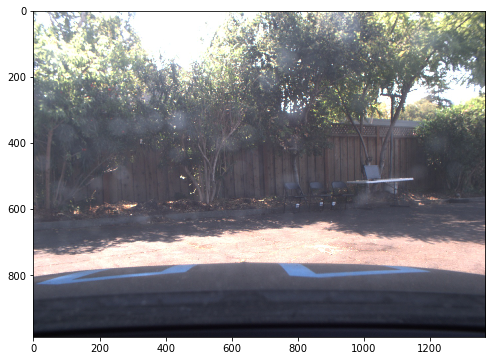

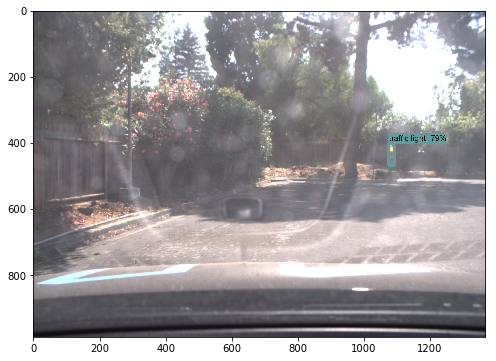

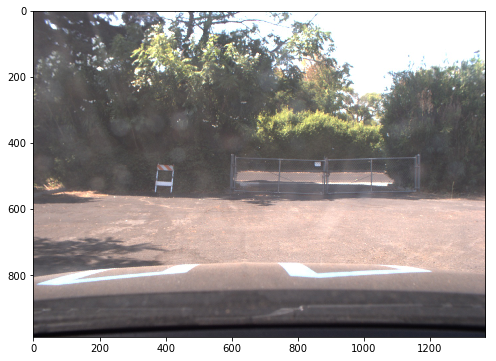

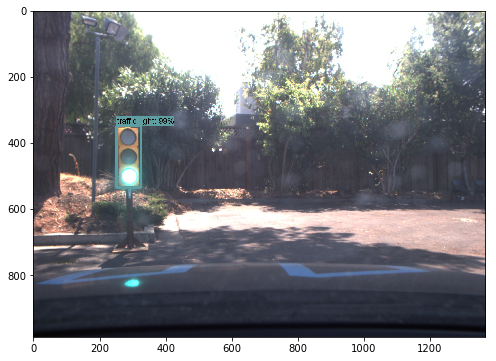

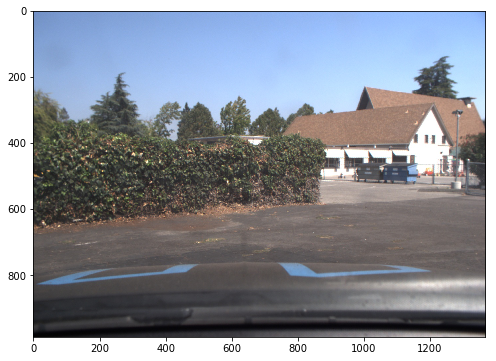

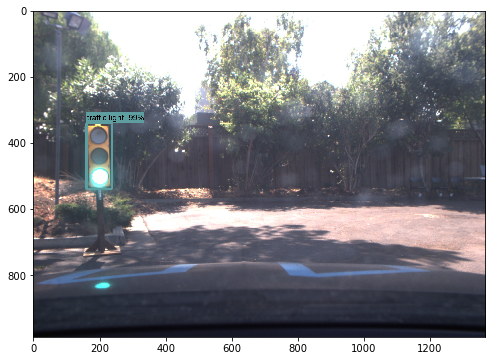

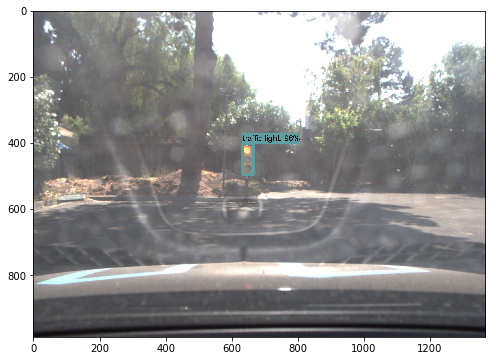

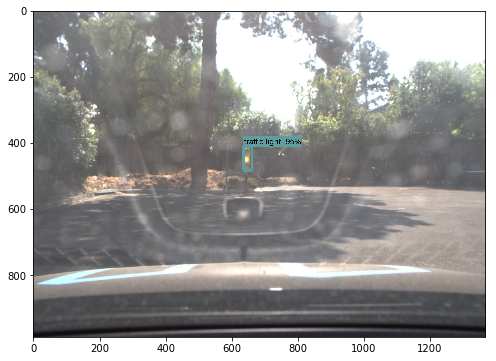

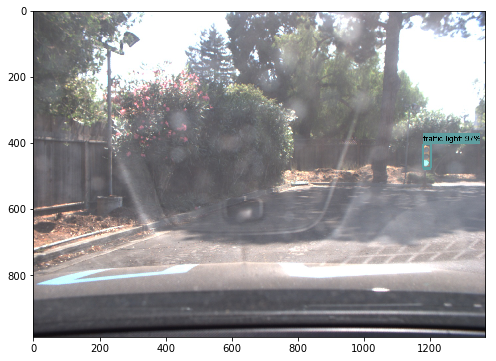

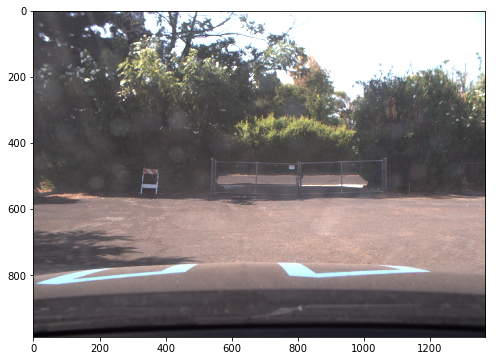

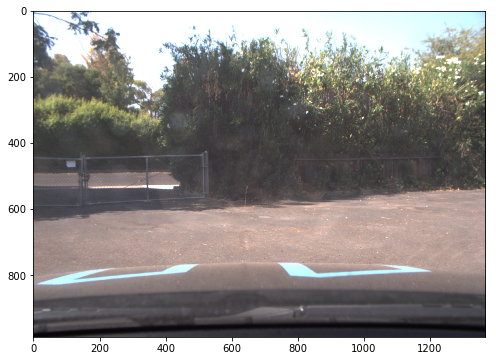

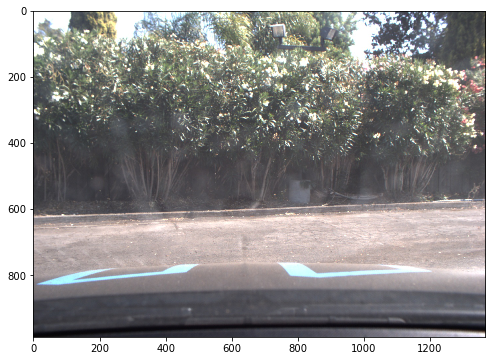

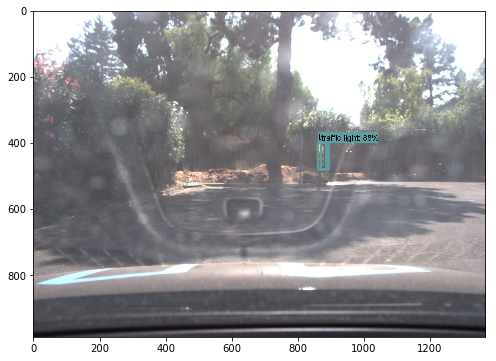

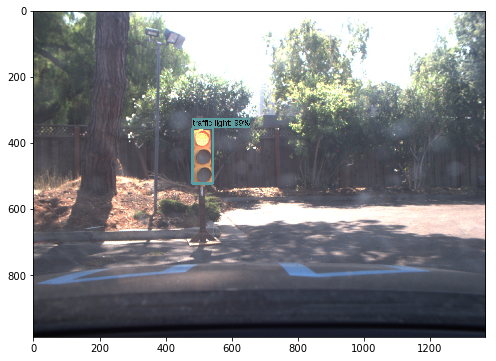

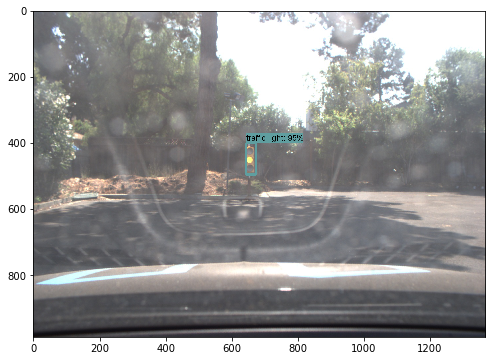

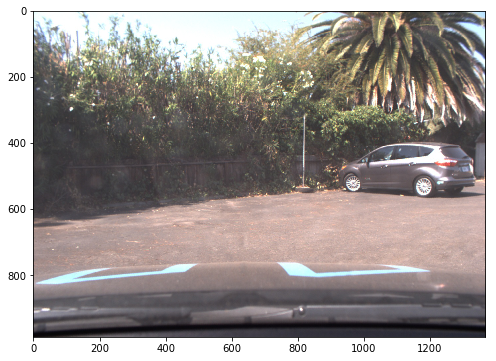

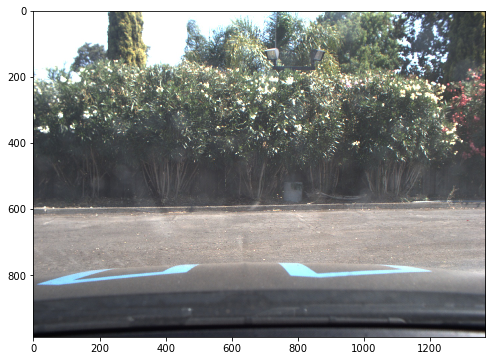

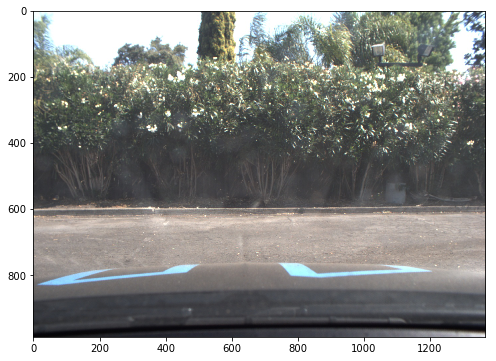

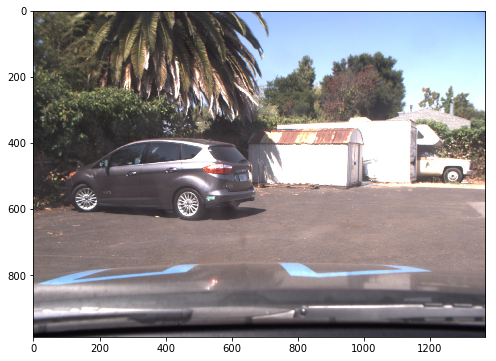

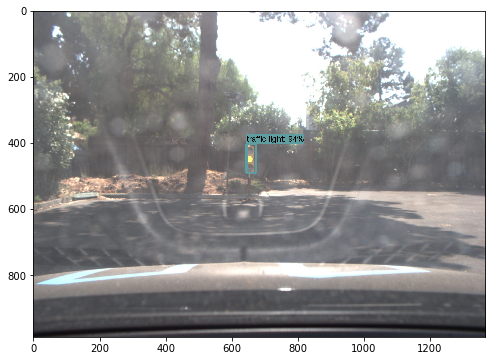

In [9]:
MIN_SCORE_THRESHOLD = .75
MAX_DETECTIONS = 10

tl_images = []

with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Crop 10% of the bottom of the image
      image_np = image_np[:-int(.1*image_np.shape[0]),:,:]
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.  
      boxes = np.squeeze(boxes)
      scores = np.squeeze(scores)
      classes = np.squeeze(classes).astype(np.int32)
    
      sorted_indexes = np.argsort(scores)
    
      tl_boxes = []
      tl_scores = []
      tl_classes = []
      for i in reversed(sorted_indexes):
        class_name = ""
        if classes[i] in category_index.keys():
          class_name = category_index[classes[i]]['name']
        if class_name == 'traffic light' and scores[i] >= MIN_SCORE_THRESHOLD:
          tl_boxes.append(boxes[i])
          tl_scores.append(scores[i])
          tl_classes.append(classes[i])
        if (len(tl_boxes) >= MAX_DETECTIONS):
            break;
        
      if len(tl_boxes) > 0:
        im_height, im_width, im_ch = image_np.shape
        for i, box in enumerate(tl_boxes):
          ymin, xmin, ymax, xmax = (int(math.floor(box[0] * im_height)), int(math.floor(box[1] * im_width)),
                                    int(math.floor(box[2] * im_height)), int(math.floor(box[3] * im_width)))
          
          tl_image = image_np[ymin:ymax,xmin:xmax,:]
          tl_image = np.copy(tl_image)
          tl_images.append(tl_image)
            
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.array(tl_boxes),
          np.array(tl_classes).astype(np.int32),
          np.array(tl_scores),
          category_index,
          min_score_thresh=MIN_SCORE_THRESHOLD,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=(12, 6))
      plt.imshow(image_np)
      plt.show()

# Classification

[ 0.71085346  0.19294299  0.09620356]
[ 0.75097781  0.1473884   0.1016338 ]


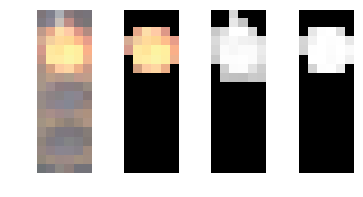

[ 0.14047003  0.14884526  0.71068472]
[ 0.14341933  0.10210693  0.75447381]


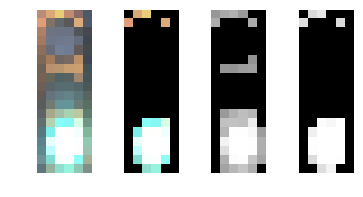

[ 0.13824891  0.15549286  0.70625824]
[ 0.13556831  0.1030428   0.76138896]


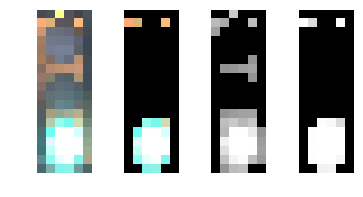

[ 0.64319652  0.23427363  0.12252981]
[ 0.77687782  0.11798327  0.10513898]


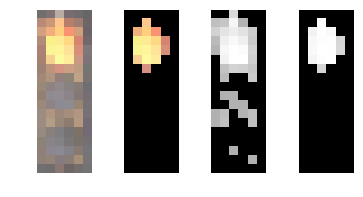

[ 0.17075229  0.69531244  0.13393527]
[ 0.13735455  0.75981557  0.10282986]


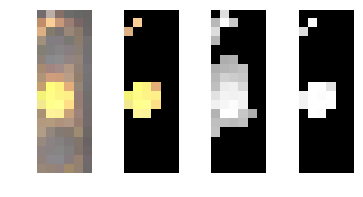

[ 0.20549272  0.16335118  0.63115609]
[ 0.16795099  0.09918268  0.73286635]


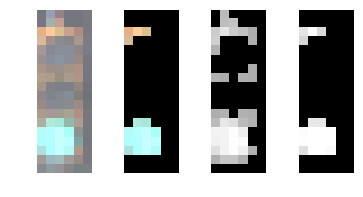

[ 0.65061373  0.24597156  0.10341468]
[ 0.78698605  0.10650699  0.10650699]


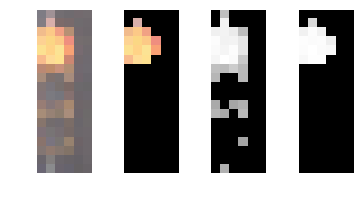

[ 0.54776651  0.33523729  0.11699624]
[ 0.78698605  0.10650699  0.10650699]


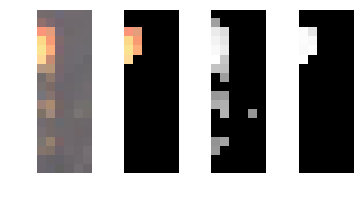

[ 0.68112367  0.15488859  0.16398777]
[ 0.73713201  0.16310805  0.09975997]


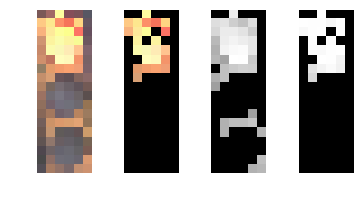

[ 0.18998067  0.65005797  0.15996133]
[ 0.18831436  0.71493036  0.0967553 ]


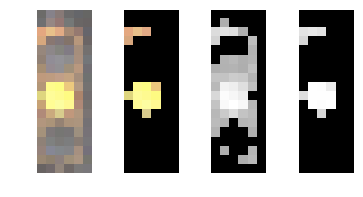

[ 0.18268052  0.66990447  0.14741501]
[ 0.15427957  0.74490809  0.10081236]


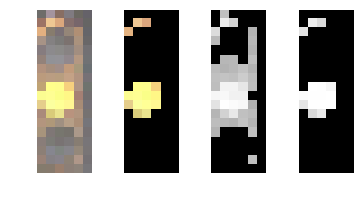

In [10]:
TRAFFIC_LIGHT_SHAPE = (6, 18)

w, h = TRAFFIC_LIGHT_SHAPE

h1 = h//3
h2 = (2 * h) // 3

HSV_V_THRESHOLD = 210

def color_threshold(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    lower_red = np.array([150, 0, HSV_V_THRESHOLD])
    upper_red = np.array([180, 255,255])
    red_mask1 = cv2.inRange(hsv[:h1,:], lower_red, upper_red)

    lower_red = np.array([0, 0, HSV_V_THRESHOLD])
    upper_red = np.array([30, 255,255])
    red_mask2 = cv2.inRange(hsv[:h1,:], lower_red, upper_red)
    
    red_mask = red_mask1 + red_mask2
    
    lower_yellow = np.array([0, 0, HSV_V_THRESHOLD]) 
    upper_yellow = np.array([60, 255, 255])    
    yellow_mask = cv2.inRange(hsv[h1:h2,:], lower_yellow, upper_yellow)
    
    lower_green = np.array([30, 0, HSV_V_THRESHOLD]) 
    upper_green = np.array([100, 255, 255])    
    green_mask = cv2.inRange(hsv[h2:,:], lower_green, upper_green)

    color_mask = np.vstack((red_mask, yellow_mask, green_mask))

    lower_white = np.array([0, 0, 245])
    upper_white = np.array([180, 10, 255])
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    
    tl_mask = cv2.bitwise_or(white_mask, color_mask)
    
    hsv[tl_mask == 0] = 0
    return hsv
    #return cv2.bitwise_and(, hsv[:,:,2], mask=tl_mask)

def denoise(image):
    average = int(round(np.sum(np.sum(image, axis=1, dtype=np.float32)) / (h*w)))
    out_image = np.copy(image)
    out_image[image <= average] = 0
    #image[image > 0] -= average
    return out_image

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e = np.exp(x)
    return e / np.sum(e, axis=0)

def get_tl_softmax(image):
    intensity = np.hstack((np.sum(np.sum(image[:h1,:], axis=1, dtype=np.float32)), 
                           np.sum(np.sum(image[h1:h2,:], axis=1, dtype=np.float32)), 
                           np.sum(np.sum(image[h2:,:], axis=1, dtype=np.float32))))
        
    max_intensity = max(intensity)
    intensity = 2 * intensity / max_intensity - 1
    return softmax(intensity)

for i, tl_image in enumerate(tl_images):
    box_h, box_w, _ = tl_image.shape
    if box_h < 2 * box_w:
        continue
        
    tl_image = cv2.resize(tl_image, TRAFFIC_LIGHT_SHAPE)

    hls = cv2.cvtColor(tl_image, cv2.COLOR_RGB2HLS)   
    hsv_masked = color_threshold(tl_image)
    tl_masked = cv2.cvtColor(hsv_masked, cv2.COLOR_HSV2RGB)
    
    filter1 = hls[:,:,1]
    filter1 = denoise(filter1)
    print(get_tl_softmax(filter1))
    
    filter2 = hsv_masked[:,:,2]
    #filter2 = denoise(filter2)
    print(get_tl_softmax(filter2))
        
    fig, axes = plt.subplots(1, 4, figsize=(6,3))
    for ax in axes:
        ax.set_axis_off()
        
    axes[0].imshow(tl_image)
    axes[1].imshow(tl_masked)            
    axes[2].imshow(filter1, cmap='gray')
    axes[3].imshow(filter2, cmap='gray')
    plt.show()